# Ultrasound propagation along the neuron fiber (Yanagita et al. 2009)

## Objectives

- Implement an ultrasound propagation based on Yanagita et al. 2009
- Model the acoustic pressure distribution along the fiber.
- Run simulations of the fiber model with various inputs, and describe results. 
- Check the dependence of the maximum stimulation amplitude on the distance to the transducer.
- Compute a strength-distance curve (threshold excitation amplitude as a function of distance to transducer) for a stimulus of a given duration.
- Compute a strength-duration curve for the transducer at a given distance.
- Find out which parameters could be validated during the experiments.

### Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from PySONIC.neurons import getPointNeuron
from ExSONIC.core import PlanarDiskTransducerSource, SonicSennFiber

## Acoustic propagation from a planar transducer

Acoustic propagation is implemented as in Yanagita et al. 2009, based on the Rayleigh–Sommerfeld integral solution for a 1D case.

The key idea of the paper is to calculate the acoustic pressure in the observation points based on the acoustic pressure of the transducer surface. The transducer surface velocity is assumed to be continuous.

### Acoustic source: planar disk transducer

Let's define a planar disk transducer at a given 2D location to represent our acoustic source.

In [10]:
Fdrive = 5000e3         # US frequency (Hz) as in Yanagita et al.
u_z = 44e-3             # transducer surface velocity (m/s)
c = 1490.0              # medium speed of sound (m/s) as in Yanagita et al.
rho = 1204.1            # medium density (kg/m3)
r_tr = (2.54e-3) / 2    # transducer radius (m)
x0 = 0                  # transducer location x-axis (m)
z0 = 0                  # transducer location z-axis (m)
psource = PlanarDiskTransducerSource(x0, z0, Fdrive, rho=rho, c=c, r=r_tr)

### 2D acoustic field

Let's compute the 2D acoustic pressure distribution generated by the transducer:

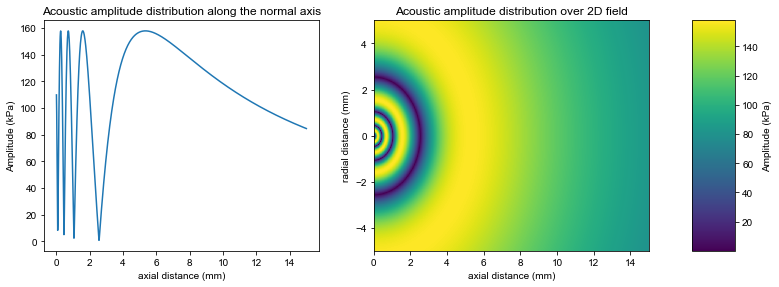

In [11]:
# Generate 2D square grid
n = 1000
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m
xx, zz = np.meshgrid(x, z)

# Compute acoustic amplitudes over 2D grid assuming radial symmetry (i.e. as if every point was along the normal axis)
r = np.sqrt((xx - x0)**2 + (zz - z0)**2).T  # distances to transducer center
amps = psource.normalAxisAmp(r, u_z)  # Pa

def plotAmpDist(x, z, amps):
    # Plot amplitude distribution along normal axis and over 2D field
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    ax.plot(z * 1e3, amps[int(x.size / 2), :] * 1e-3)
    ax = axes[1]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * 1e3, x * 1e3, amps * 1e-3, cmap='viridis')
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    return fig

fig = plotAmpDist(x, z, amps)

The obtained results along the normal axis correspond well to the Figure 2 in Yanagita et al. 2009. The difference in the obtained pressure values is due to the unknown values of the transducer surface velocity and medium density taken in the paper.

However, we can see that the pressure amplitudes distributions along the different angles are exactly the same. This means that with the different angle of incidence of the transducer nothing will change in our model.

### Acoustic distribution along fiber

Let's check how the resulting acoustic pressure distribution along the different nodes of a fiber placed orthogonally to the acoustic propagation axis.

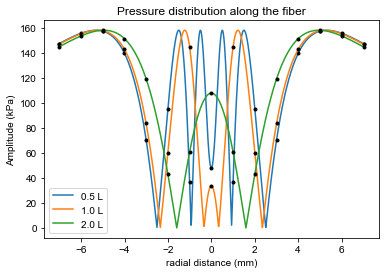

In [12]:
# Fiber model parameters
pneuron = getPointNeuron('FH')  # Frog myelinated node membrane equations
fiberD = 10e-6                  # fiber diameter (m)
rho_a = 54.7                    # axoplasm resistivity (Ohm.cm)
d_ratio = 0.6                   # axon / fiber diameter ratio
nodeL = 1.5e-6                  # node length (m)
a = 32e-9                       # sonophore diameter (m)
Fdrive = 500e3                  # US frequency (Hz)
fs = 1                          # sonophore membrane coverage (-)
nnodes = 15
fiber = SonicSennFiber(
    pneuron, fiberD, nnodes, a=a, Fdrive=Fdrive, rs=rho_a, nodeL=nodeL, d_ratio=d_ratio)

def plotFiberAmpDist(psource, fiber, rel_distances):
    xnodes = fiber.getNodeCoords()
    xdense = np.linspace(xnodes.min(), xnodes.max(), 1000)
    fig, ax = plt.subplots()
    ax.set_title('Pressure distribution along the fiber')
    ax.set_xlabel('radial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    unit_nodes = np.ones(xnodes.size)
    unit_dense = np.ones(xdense.size)
    for i, rel_z in enumerate(rel_distances):
        z = fiber.interL * rel_z
        amps_nodes = psource.normalAxisAmp(psource.distance(unit_nodes * z, xnodes), u_z)  # Pa
        amps_dense = psource.normalAxisAmp(psource.distance(unit_dense * z, xdense), u_z)  # Pa
        ax.plot(xdense * 1e3, amps_dense * 1e-3, c=f'C{i}', label=f'{rel_z} L')
        ax.plot(xnodes * 1e3, amps_nodes * 1e-3, '.', c='k')
    ax.legend()
    return fig

rel_distances = [0.5, 1., 2.]
fig = plotFiberAmpDist(psource, fiber, rel_distances)

### <span style="color:red">TODO: comment on profile variation</span>

## Simulations

Let's compute the response of the fiber to supra-threshold sonication while varying the transducer-fiber distance:  

### <span style="color:red">TODO: run simulations with corrected pressure distributions</span>

In [13]:
# code goes here

### <span style="color:red">TODO: adapt discussion</span>

- With the stimulation onset first thing we see is the rapid voltage drop in all of the nodes. The US stimulus generates an instantaneous drops in effective membrane capacitances of the nodes that hyperpolarize $V_{m}s$ to a values far below their resting potentials. These initial voltage drops in the nodes are followed by the rapid changes in the corresponding charges. The membrane charge densities in the nodes progressively increase due to the leakage currents. This is happening until the spiking-thresholds. At this point neuron starts its spiking. After the start of the stimulation all the neigbouring nodes are trying to synchronize with one another. $V_ms$ imbalances drive significant axial currents that equilibrate the membrane potentials of the nodes almost instantaneously to an intermediate value (ca. -75 $mV$). This equilibration through axial currents drives instantaneous changes in membrane charge density (increase at the currently stimulated node, decrease at the neighbouring nodes). However, this increase is smaller than for the case when only the central node is stimulated as now all the other nodes are also stimulated. The time constants are higher for the nodes that are located further from the center, though. This is due to that it takes more time for the pressure to travel there. After the stimulation onset the axial currents from the nodes increase the membrane charge densities at the neighboring nodes in order to equilibrate the effective membrane potentials.<br>

There is a one major change comparing to the case when only the central node is stimulated. There is not only a one bump in a rising phase in the system but 3 equal to the number of nodes divided by 2. This can be explained as the following. The capacitances of the node membranes are dependent on the membrane charge densities. These capacitances also affect membrane potentials. At about 1 ms for the case when the transucer is 0.0005 m away from the fiber the membrane charge density in the central node reaches a treshold when the membrane capacitance in the central node changes. This leads to the rapid change in the membrane voltage at this node. The drop in the capacitance leads to an increase in the absolute value of voltage at the node. The neigbouring nodes are following the behaviour of the cental one. However, they are also stimulated so the changes do not affect them so much as in the previous case.  Nevertheless, the membrane charge density continues to rise. Thus, at some point the capacitance bump finishes, which leads to a rise of the membrane voltage with the charge density. The same bump behaviour could be noticed for the nodes 1 and 3 at about 10 ms and for the nodes 0 and 4 at about 15 ms after the stimulation onset. It is noticeable that all of the nodes reach the point where the membrane charge density there is about -127 nC/cm^2. This value corresponds to a big bump in a capacitance graph.<br>
It seems that the further the trancducer is away it takes longer for the first bump to be elicited but the bumps in the other nodes happen faster. Also the amplitudes of these bumps on the voltage graph rise with the increase in the distance.

- At the spiking phase $Q_ms$ reach a threshold value at the nodes which drive ion channels opening and trigger spikes. In terms of voltages the nodes behaviors are exactly the same as they are locked with the axial-driven currents. They are also the same in terms of charge density variations since all the nodes effective electrical systems are modulated by US.
- With the stimulus offset the effective membrane capacitances of the nodes restore to their resting values which can be seen in a rapid voltage changes. Both $Q_ms$ and $V_ms$ evolve in synchrony. <br>

The further away the trancducer the closer voltage change values are and the more synchronized the graphs. This could be measured during the experimental validation phase as we will have direct access to the membrane voltage data.

## Strength-distance curve

Let's compute the threshold normal particle velocity on the transducer surface required to excite the fiber, at various fiber-transducer locations:

### <span style="color:red">TODO: re-compute strength-distance curve with corrected pressure distributions</span>

In [14]:
# code goes here

### <span style="color:red">TODO: adapt discussion</span>

As can be seen from the graph, the transducer surface velocity needed to elicit the spike rises with the increase of the distance to the transducer. It takes more power to elicit the spikes when the transducer is further away from the neuron fiber.

## Strength-duration curve

Let's compute the threshold normal particle velocity on the transducer surface required to excite the fiber at a given distance, for various stimulus durations:

### <span style="color:red">TODO: re-compute strength-durations curve with corrected pressure distributions</span>

In [15]:
# code goes here

### <span style="color:red">TODO: adapt discussion</span>

As can be seen from the graph the transducer velocity surface needed to elicit the spike falls with the distance. The chronaxie is calculated and shown.

## Conclusions

### <span style="color:red">TODO: adapt conclusions</span>

- The ultrasound propagation along the neuron fiber is validated on the Yanagita et al. 2009 paper results.
- The NEURON model of the ultrasound propagation along the fiber is created.
- There are simulation parameters which can be measured during the in-vivo experiments.
- The strength-location curve obtained from the simulation data makes empirical sense.
- The strength-duration curve obtained from the simulation data makes empirical sense.

## References
- Yanagita T., Kundu T., Placko D., "Ultrasonic field modeling by distributed point source method for different transducer boundary conditions.", J. Acoust. Soc. Am. 2009 Nov; 126(5):2331-9. doi: 10.1121/1.3203307. https://bit.ly/2kiNwaS

